In [ ]:
!pip install --upgrade gensim --quiet
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [2]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [3]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

In [4]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [5]:
# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    #words = sentence.split()
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

In [6]:
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']


In [7]:
qwe = raw_table_data[columns_to_filter].quantile(0.99)

In [8]:
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < qwe).all(axis=1)]


In [9]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

In [10]:
# Убираем из датасета лишние столбцы
# Формируем датасет для AutoML методов
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()


**AutoML H2O**

In [11]:
!pip install h2o --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.3 MB/s eta 0:00:00


In [12]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [13]:
# Инициализируем H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8owd79cr
  JVM stdout: /tmp/tmp8owd79cr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8owd79cr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_m1v9d3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [14]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

AutoML progress: |
08:56:48.797: Project: AutoML_1_20250514_85648
08:56:48.799: 5-fold cross-validation will be used.
08:56:48.802: Setting stopping tolerance adaptively based on the training frame: 0.018579146207522112
08:56:48.803: Build control seed: 17
08:56:48.804: training frame: Frame key: AutoML_1_20250514_85648_training_py_2_sid_bc06    cols: 10    rows: 2897  chunks: 1    size: 586490  checksum: -8106621696533971404
08:56:48.804: validation frame: NULL
08:56:48.804: leaderboard frame: NULL
08:56:48.804: blending frame: NULL
08:56:48.804: response column: Healthy_Status
08:56:48.805: fold column: null
08:56:48.805: weights column: null
08:56:48.837: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]

In [16]:
lb = automl.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250514_85648,0.0884861,0.00782979,0.0348143,0.0613202,0.00782979
StackedEnsemble_BestOfFamily_2_AutoML_1_20250514_85648,0.0947682,0.00898102,0.0393005,0.0646408,0.00898102
StackedEnsemble_BestOfFamily_1_AutoML_1_20250514_85648,0.0966911,0.00934917,0.043961,0.0673314,0.00934917
GBM_1_AutoML_1_20250514_85648,0.0994594,0.00989218,0.0430304,0.0709556,0.00989218
DRF_1_AutoML_1_20250514_85648,0.102722,0.0105519,0.0280444,0.06788,0.0105519
GBM_2_AutoML_1_20250514_85648,0.109042,0.0118902,0.070092,0.0776248,0.0118902
GLM_1_AutoML_1_20250514_85648,0.12051,0.0145227,0.0553094,0.0817949,0.0145227
GBM_3_AutoML_1_20250514_85648,0.123368,0.0152198,0.0848824,0.0834753,0.0152198
XGBoost_2_AutoML_1_20250514_85648,0.146399,0.0214328,0.0708143,0.105343,0.0214328
XGBoost_1_AutoML_1_20250514_85648,0.172452,0.0297397,0.0857152,0.125111,0.0297397


In [17]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_AllModels_1_AutoML_1_20250514_85648',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250514_85648',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20250514_85648',
 'GBM_1_AutoML_1_20250514_85648',
 'DRF_1_AutoML_1_20250514_85648',
 'GBM_2_AutoML_1_20250514_85648',
 'GLM_1_AutoML_1_20250514_85648',
 'GBM_3_AutoML_1_20250514_85648',
 'XGBoost_2_AutoML_1_20250514_85648',
 'XGBoost_1_AutoML_1_20250514_85648',
 'GBM_4_AutoML_1_20250514_85648',
 'GBM_5_AutoML_1_20250514_85648',
 'XGBoost_3_AutoML_1_20250514_85648',
 'XRT_1_AutoML_1_20250514_85648']

In [18]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 5.0,
  'nthread': 2,
  'seed': 21,
  'max_bin': 256,
  'max_depth': 10,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'gpu_id': 0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 11,
  'subsample': 0.6,
  'max_delta_step': 0.0,
  'tree_method': 'gpu_hist'},
 11)

In [19]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.005732600272087805
RMSE: 0.07571393710597676
MAE: 0.033536073590253256
RMSLE: 0.053575361005917255
Mean Residual Deviance: 0.005732600272087805
R^2: 0.9698946325474955
Null degrees of freedom: 507
Residual degrees of freedom: 502
Null deviance: 97.12591185887521
Residual deviance: 2.9121609382206053
AIC: -1166.4441644388203

In [20]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


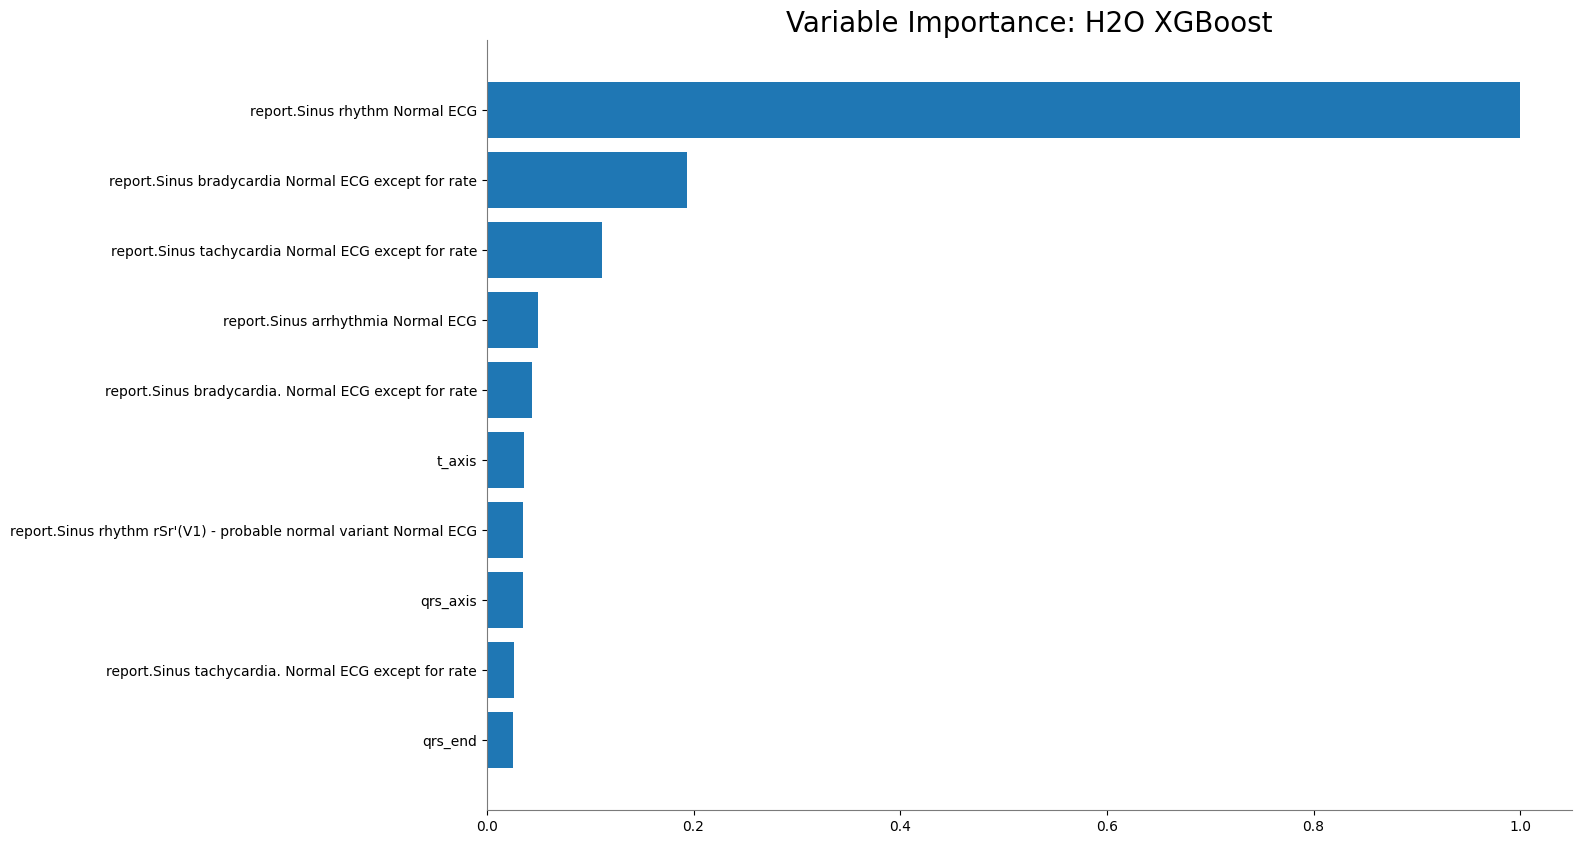

<Figure size 640x480 with 0 Axes>

In [21]:
out.varimp_plot()

In [22]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [23]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [24]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[378   0]
 [  2 128]]
F1-Score:  0.99
Accuracy: 1.00
Recall:  0.98
Precision:  1.00


In [25]:
# Завершение работы H2O
h2o.shutdown()

H2O session _sid_bc06 closed.


<ipython-input-25-9ae954ad13ba>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


**AutoML AutoGluon**

In [12]:
!pip uninstall -y numpy scipy gensim tsfresh

# Install compatible versions
!pip install numpy==1.26.4 scipy==1.14.0 gensim==4.3.3 tsfresh==0.21.0 --quiet

# Install other required packages (e.g., scikit-learn and autogluon)
!pip uninstall -y scikit-learn autogluon
!pip install scikit-learn==1.4.2 autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: tsfresh 0.21.0
Uninstalling tsfresh-0.21.0:
  Successfully uninstalled tsfresh-0.21.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.5 MB/s eta 0:00:00
ERROR: Cannot install gensim==4.3.3 and scipy==1.14.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: autogluon 1.3.0
Uninstalling autogluon-1.3.0:
  Successfully uninstalle

In [11]:
!pip install autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.2 MB/s eta 0:00

In [13]:
import autogluon

In [16]:
# Uninstall conflicting packages
!pip uninstall -y scikit-learn autogluon

# Install compatible versions
!pip install scikit-learn==1.4.2 --quiet
!pip install autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

# Restart runtime after installation (manual step)
# After running this, manually select Runtime > Restart runtime
# exit()

# Verify installations
import sklearn
import importlib.metadata

print(f"scikit-learn: {sklearn.__version__}")
try:
    autogluon_version = importlib.metadata.version("autogluon")
    print(f"autogluon: {autogluon_version}")
except Exception as e:
    print(f"Could not retrieve autogluon version: {e}")

# Test the import
from autogluon.tabular import TabularPredictor
print("Import successful!")

Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: autogluon 1.3.0
Uninstalling autogluon-1.3.0:
  Successfully uninstalled autogluon-1.3.0
scikit-learn: 1.6.1
autogluon: 1.3.0


ImportError: cannot import name '_is_pandas_df' from 'sklearn.utils' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py)

In [14]:
autoML_df.head()

,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,Sinus rhythm Possible right atrial abnormality...,659,128,170,258,518,81,77,79,0
1,Sinus rhythm Possible right atrial abnormality...,722,124,162,246,504,77,75,70,0
2,Sinus tachycardia Normal ECG except for rate,600,130,162,244,474,79,72,77,1
3,Sinus rhythm Normal ECG,659,146,180,254,538,79,66,69,1
6,Sinus rhythm Normal ECG,952,146,198,282,598,24,80,20,1


In [17]:
# Разбиение на обучающую и тестовую выборки
random_seed = 17

# set the classification index of table
clf_index = 9

target = 'Healthy_Status'

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(
                                                        auto_X, auto_Y,
                                                        train_size=0.85,
                                                        random_state=random_seed,
                                                        stratify=auto_Y
                                                        )

# Создаем обучающий датафрейм
auto_train_df = auto_X_train.copy()
auto_test_df = auto_X_test.copy()
auto_train_df['Healthy_Status'] = auto_Y_train
auto_test_df['Healthy_Status'] = auto_Y_test

In [31]:
# Создаем и обучаем модель
predictor = TabularPredictor(label='Healthy_Status', eval_metric='accuracy').fit(train_data=auto_train_df)

# Предсказание на тестовой выборке
y_pred = predictor.predict(auto_X_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20250514_090432"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       11.19 GB / 12.67 GB (88.3%)
Disk Space Avail:   69.06 GB / 112.64 GB (61.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

In [32]:
predictor.leaderboard(auto_test_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,1.000000,1.000,accuracy,0.004157,0.009009,0.409153,0.004157,0.009009,0.409153,1,True,4
1,LightGBMXT,1.000000,1.000,accuracy,0.004603,0.003907,3.554223,0.004603,0.003907,3.554223,1,True,3
2,LightGBMLarge,1.000000,1.000,accuracy,0.005359,0.006007,1.119450,0.005359,0.006007,1.119450,1,True,13
3,CatBoost,1.000000,1.000,accuracy,0.013286,0.010247,3.070547,0.013286,0.010247,3.070547,1,True,7
4,XGBoost,1.000000,1.000,accuracy,0.013329,0.008945,1.911509,0.013329,0.008945,1.911509,1,True,11
5,WeightedEnsemble_L2,1.000000,1.000,accuracy,0.014799,0.009687,2.003468,0.001470,0.000742,0.091959,2,True,14
6,ExtraTreesGini,1.000000,1.000,accuracy,0.094222,0.086828,0.763214,0.094222,0.086828,0.763214,1,True,8
7,ExtraTreesEntr,1.000000,1.000,accuracy,0.095097,0.087651,0.764408,0.095097,0.087651,0.764408,1,True,9
8,RandomForestEntr,1.000000,1.000,accuracy,0.100219,0.076435,1.094562,0.100219,0.076435,1.094562,1,True,6
9,RandomForestGini,1.000000,1.000,accuracy,0.100246,0.072958,1.415392,0.100246,0.072958,1.415392,1,True,5


In [18]:
!pip install --quiet flaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 10.8 MB/s eta 0:00:00


In [16]:
!pip install autogluon.eda --quiet

ERROR: Ignored the following versions that require a different python version: 0.6.3b20230126 Requires-Python >=3.8, <3.11; 0.6.3b20230127 Requires-Python >=3.8, <3.11; 0.6.3b20230128 Requires-Python >=3.8, <3.11; 0.6.3b20230129 Requires-Python >=3.8, <3.11; 0.6.3b20230130 Requires-Python >=3.8, <3.11; 0.6.3b20230131 Requires-Python >=3.8, <3.11; 0.6.3b20230201 Requires-Python >=3.8, <3.11; 0.6.3b20230202 Requires-Python >=3.8, <3.11; 0.6.3b20230203 Requires-Python >=3.8, <3.11; 0.6.3b20230204 Requires-Python >=3.8, <3.11; 0.6.3b20230205 Requires-Python >=3.8, <3.11; 0.6.3b20230206 Requires-Python >=3.8, <3.11; 0.6.3b20230207 Requires-Python >=3.8, <3.11; 0.6.3b20230208 Requires-Python >=3.8, <3.11; 0.6.3b20230209 Requires-Python >=3.8, <3.11; 0.6.3b20230210 Requires-Python >=3.8, <3.11; 0.6.3b20230211 Requires-Python >=3.8, <3.11; 0.6.3b20230212 Requires-Python >=3.8, <3.11; 0.6.3b20230213 Requires-Python >=3.8, <3.11; 0.6.3b20230214 Requires-Python >=3.8, <3.11; 0.6.3b20230215 Requir

In [34]:
import autogluon.eda.auto as auto

ModuleNotFoundError: No module named 'autogluon.eda'

In [35]:
!pip install autogluon==1.2 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.0/430.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.

In [36]:
# scikit-learn moves the check_pandas_support api,
# HAVE TO downgrade to scikit-learn <= 1.4.2 can solve the problem
!pip install scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [18]:
!pip install --quiet pandas-profiling

from pandas_profiling import ProfileReport

profile = ProfileReport(auto_train_df, title="EDA Report", explorative=True)
profile.to_notebook_iframe()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 21.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.4.2 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.


AttributeError: module 'numba' has no attribute 'generated_jit'

In [ ]:
auto.dataset_overview(train_data=auto_train_df,
                      test_data=auto_test_df,
                      label=target)

In [ ]:
predictor.quick_fit(auto_train_df, target_col=target, show_feature_importance_barplots=True)


**AutoML BlueCast**



In [19]:
!pip install bluecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 123.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.0 which is incompatible.
autogluon-features 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-core 1.2 requires scikit-learn<1.5.3,>=1.4.0, bu

In [21]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

ImportError: cannot import name 'validate_data' from 'sklearn.utils.validation' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py)

In [20]:
# Установка зависимостей с исправлением конфликтов
!pip uninstall -y scikit-learn autogluon numpy pandas h2o fedot lightautoml gama pycaret torch transformers -y --quiet



In [21]:
# Установка базовых зависимостей
!pip install --force-reinstall scikit-learn==1.4.2 numpy==1.26.4 pandas==2.2.2 --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.0 requires torch<2.2,>=2.1, which is not installed.
autogluon-multimodal 1.1.0 requires transformers[sentencepiece]<4.39.0,>=4.38.0, which is not installed.
torchvision 0.16.2 requires torch==2.1.2, which is not installed.
accelerate 0.21.0 requires torch>=1.10.0, which is not installed.
optimum 1.18.1 requires torch>=1.11, which is not installed.
optimum 1.18.1 requires transformers[sentencepiece]<4.40.0,>=4.26.0, which is not installed.
timm 0.9.16 requires torch, which is not installed.
pytorch-metric-learning 2.3.0 requires torch>=1.6.0, which is not installed.
torchmetrics 1.2.1 requires torch>=1.8.1, which is not installed.
pytorch-lightning 2.1.4 requires torch>=1.12.0, which is not installed.
autogluon-timeseries 1.1.0 requires torch<2.2,>=2.1, which is not installed.
autogluon-tim

In [22]:
# Установка AutoGluon
!pip install autogluon==1.1.0 --quiet
!pip install autogluon.tabular[lightgbm] --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.1 requires scikit-learn>=1.6.0, but you have scikit-learn 1.4.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.1.2 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.


In [23]:

# Установка H2O
!pip install h2o==3.46.0.1 --quiet


In [24]:

# Установка BlueCast
!pip install bluecast==1.0.0 --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-core 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-features 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-tabular 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.


In [12]:

# Установка Fedot и его зависимостей
!pip install torch==2.1.2 --quiet  # Fedot требует совместимую версию torch
!pip install fedot==0.7.2 --quiet



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Cannot install fedot because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [26]:
# Установка LightAutoML
!pip install lightautoml==0.3.8 --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.0 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-multimodal 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-multimodal 1.1.0 requires torch<2.2,>=2.1, but you have torch 2.0.0 which is incompatible.
torchvision 0.16.2 requires torch==2.1.2, but you have torch 2.0.0 which is incompatible.
autogluon-core 1.1.0 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-core 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-features 1.1.0 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-features 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1

In [27]:

# Установка GAMA
!pip install gama==23.0.0.post1 --quiet


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.0 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-multimodal 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.2.2 which is incompatible.
autogluon-multimodal 1.1.0 requires torch<2.2,>=2.1, but you have torch 2.0.0 which is incompatible.
autogluon-core 1.1.0 requi

In [28]:

# Установка PyCaret
!pip install pycaret==3.3.2 --no-deps --quiet


In [29]:

# Установка transformers для sentence-transformers
!pip install transformers==4.41.0 --quiet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.0 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-multimodal 1.1.0 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.2.2 which is incompatible.
autogluon-multimodal 1.1.0 requires torch<2.2,>=2.1, but you have torch 2.0.0 which is incompatible.
autogluon-multimodal 1.1.0 requires transformers[sentencepiece]<4.39.0,>=4.38.0, but you have transformers 4.41.0 which is incompatible.
optimum 1.18.1 requires transformers[sentencepiece]<4.40.0,>=4.26.0, but you have transformers 4.41.0 which is incompatible.
au

In [1]:
# Restart runtime after installation
# After running this, manually select Runtime > Restart runtime
# exit()

# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [2]:

# Загрузка и предобработка данных
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv')
columns = ['Count_subj', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']
data = raw_table_data[columns]
data = data.replace(29999, np.nan).replace(32767, np.nan).dropna()
X = data.drop('Healthy_Status', axis=1)
y = data['Healthy_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Хранилище для результатов
f1_scores = {}


In [7]:
# ... (previous imports and data preprocessing remain the same)

# 1. H2O
print("Training with H2O...")
import h2o
from h2o.automl import H2OAutoML
h2o.init()

# Преобразуем Healthy_Status в категориальный тип и убедимся, что все признаки числовые
train_df = pd.concat([X_train, y_train], axis=1)
train_df['Healthy_Status'] = train_df['Healthy_Status'].astype('category')
# Преобразуем все остальные столбцы в числовой тип, если есть нечисловые
for col in train_df.columns:
    if col != 'Healthy_Status':
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(X_test)

# Увеличиваем время выполнения и добавляем отладочную информацию
aml = H2OAutoML(max_runtime_secs=600, seed=42, sort_metric='f1', verbosity='info')
aml.train(y='Healthy_Status', training_frame=h2o_train)

# Проверяем лидерборд, чтобы убедиться, что модели были построены
lb = aml.leaderboard
print(lb)

h2o_pred = aml.leader.predict(h2o_test)
y_pred_h2o = h2o.as_data_frame(h2o_pred)['predict'].values
f1_h2o = f1_score(y_test, y_pred_h2o, average='binary')
f1_scores['H2O'] = f1_h2o
print(f"H2O F1 Score: {f1_h2o}")

# ... (остальной код для других фреймворков остается без изменений)

Training with H2O...
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,5 mins 17 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 year and 2 months
H2O_cluster_name:,H2O_from_python_unknownUser_89rdvw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.159 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
13:27:54.641: Project: AutoML_2_20250514_132754
13:27:54.641: 5-fold cross-validation will be used.
13:27:54.641: Setting stopping tolerance adaptively based on the training frame: 0.013320315386177048
13:27:54.641: Build control seed: 42
13:27:54.641: training frame: Frame key: AutoML_2_20250514_132754_training_Key_Frame__upload_b0df37288f17fc7d97b2c749ad1049cd.hex    cols: 10    rows: 5636  chunks: 1    size: 91563  checksum: 4106181481193104546
13:27:54.641: validation frame: NULL
13:27:54.642: leaderboard frame: NULL
13:27:54.642: blending frame: NULL
13:27:54.642: response column: Healthy_Status
13:27:54.642: fold column: null
13:27:54.642: weights column: null
13:27:54.642: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 9

OSError: Job with key $03017f00000132d4ffffffff$_9863a445f887332a937813ed499945cc failed with an exception: water.exceptions.H2OAutoMLException: Aborting AutoML after too many consecutive model failures
stacktrace: 
water.exceptions.H2OAutoMLException: Aborting AutoML after too many consecutive model failures
	at ai.h2o.automl.AutoML.learn(AutoML.java:776)
	at ai.h2o.automl.AutoML.run(AutoML.java:494)
	at ai.h2o.automl.H2OJob$1.compute2(H2OJob.java:33)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [4]:

# 2. AutoGluon
print("Training with AutoGluon...")
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='Healthy_Status', eval_metric='f1').fit(train_data=pd.concat([X_train, y_train], axis=1), time_limit=300)
y_pred_autogluon = predictor.predict(X_test)
f1_autogluon = f1_score(y_test, y_pred_autogluon, average='binary')
f1_scores['AutoGluon'] = f1_autogluon
print(f"AutoGluon F1 Score: {f1_autogluon}")


Training with AutoGluon...


No path specified. Models will be saved in: "AutogluonModels/ag-20250514_132451"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20250514_132451"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 1

AutoGluon F1 Score: 0.6651884700665188


Training with BlueCast...
2025-05-14 13:34:31.572852: Start checking if GPU is available for usage.
Xgboost uses GPU.
2025-05-14 13:34:31.579344: Start detecting and casting feature types.
2025-05-14 13:34:31.597373: Start executing train-test split with train size of 0.8.
2025-05-14 13:34:31.608724: Start filling infinite values.
2025-05-14 13:34:31.609745: Start filling infinite values.
2025-05-14 13:34:31.610601: Start date column conversion.
2025-05-14 13:34:31.610665: Start date column conversion.
2025-05-14 13:34:31.610701: Start fitting DataFrame schema.
2025-05-14 13:34:31.610732: Start checking if DataFrame schema of new data is consistent with previous data.
2025-05-14 13:34:31.612171: Start checking if DataFrame schema of new data is consistent with previous data.
2025-05-14 13:34:31.613875: Start fitting binary target encoder.
2025-05-14 13:34:31.618136: Start transforming categories with binary target encoder.
2025-05-14 13:34:31.620039: Start fitting binary target encoder

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning:

Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning:

Cross validation is disabled. Update the TrainingConfig param 'hypertuning_cv_folds'
            to enable it. Cross validation is disabled on default to allow fast prototyping. For robust hyperparameter
            tuning using at

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:42] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:45] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:47] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:52] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:34:57] WARNING: /workspace/

Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 2, 'alpha': 5.121922633857766, 'lambda': 8.126209616521136, 'gamma': 6.1252606682938815, 'max_leaves': 0, 'subsample': 0.8052287222022596, 'colsample_bytree': 0.5043132477194432, 'colsample_bylevel': 0.9424418857590604, 'eta': 0.286064610512286, 'steps': 715, 'device': 'cuda'}
Finished hyperparameter tuning
Start final model training


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:36:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.



Finished training


<ipython-input-10-e69bee1b85bc>:7: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/usr/local/lib/python3.11/dist-packages/bluecast/blueprints/cast.py:396: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/usr/local/lib/python3.11/dist-packages/bluecast/blueprints/cast.py:396: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



<Figure size 640x480 with 0 Axes>

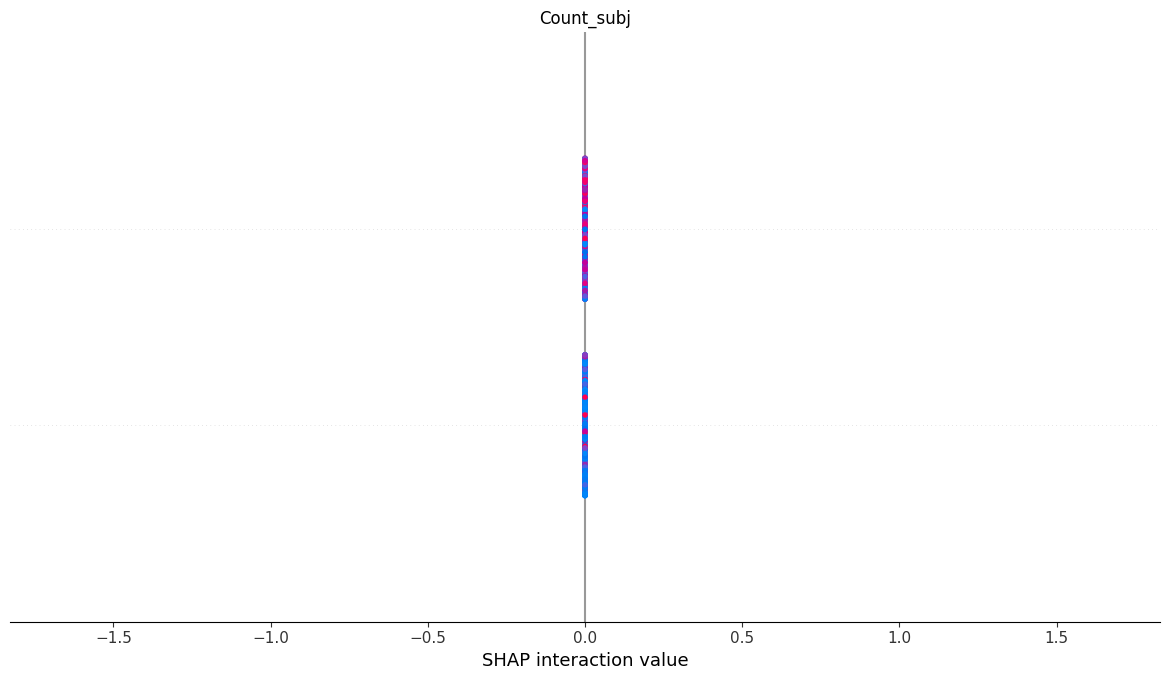

Show SHAP waterfall plot for idx 0 and target class.


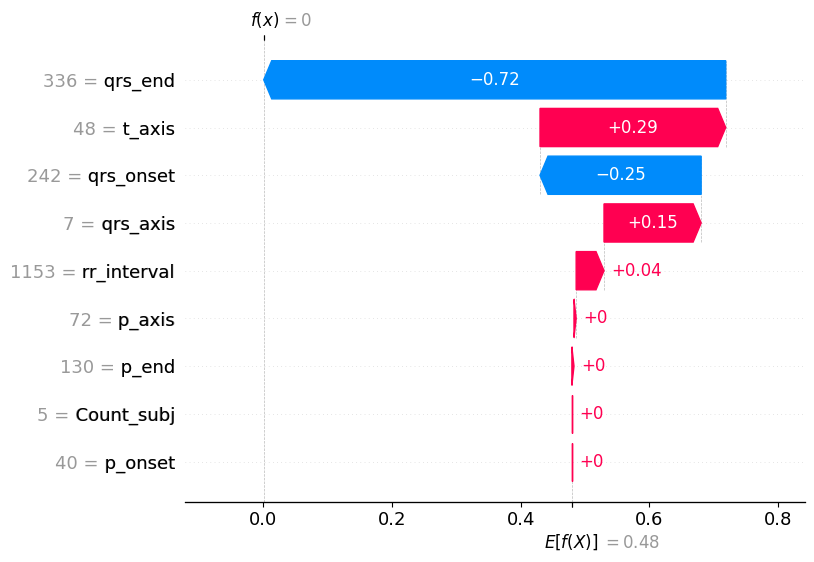

Plotting interactions of most important features by global SHAP values...
Showing dependence plots f top features for class 0...


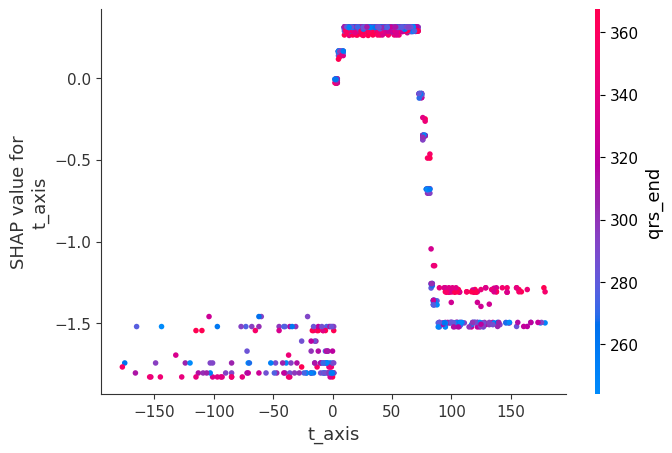

2025-05-14 13:36:56.315908: Start checking if GPU is available for usage.
Xgboost uses GPU.
2025-05-14 13:36:56.322732: Start checking if GPU is available for usage.
Xgboost uses GPU.
2025-05-14 13:36:56.327794: Start casting feature types.
2025-05-14 13:36:56.335089: Start filling infinite values.
2025-05-14 13:36:56.336382: Start date column conversion.
2025-05-14 13:36:56.336458: Start checking if DataFrame schema of new data is consistent with previous data.
2025-05-14 13:36:56.337992: Start transforming categories with binary target encoder.
2025-05-14 13:36:56.340979: Predicting...
2025-05-14 13:36:56.341069: Start predicting on new data using Xgboost model.
Finished predicting


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[13:36:56] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.



AttributeError: 'tuple' object has no attribute 'shape'

In [10]:
# ... (previous imports and data preprocessing remain the same)

# 3. BlueCast
print("Training with BlueCast...")
from bluecast.blueprints.cast import BlueCast
bluecast = BlueCast(class_problem='binary')
bluecast.fit(pd.concat([X_train, y_train], axis=1), target_col='Healthy_Status')

# Make predictions and debug the output
y_pred_bluecast = bluecast.predict(X_test)
print("Shape of y_pred_bluecast:", y_pred_bluecast.shape)  # Debug: Check the shape
print("y_pred_bluecast head:", y_pred_bluecast.head())     # Debug: Check the content

# Extract predictions (assuming it returns a DataFrame with a 'prediction' column)
if isinstance(y_pred_bluecast, pd.DataFrame):
    y_pred_bluecast = y_pred_bluecast['prediction']  # Adjust based on actual column name

# Compute F1 score
f1_bluecast = f1_score(y_test, y_pred_bluecast, average='binary')
f1_scores['BlueCast'] = f1_bluecast
print(f"BlueCast F1 Score: {f1_bluecast}")

# ... (rest of the code for other frameworks remains unchanged)

In [13]:

# 4. Fedot
print("Training with Fedot...")
from fedot.api.main import Fedot
fedot_model = Fedot(problem='classification', timeout=5, seed=42)
fedot_model.fit(features=X_train, target=y_train)
y_pred_fedot = fedot_model.predict(X_test)
f1_fedot = f1_score(y_test, y_pred_fedot, average='binary')
f1_scores['Fedot'] = f1_fedot
print(f"Fedot F1 Score: {f1_fedot}")



Training with Fedot...


ModuleNotFoundError: No module named 'fedot'

In [14]:
# 5. LightAutoML
print("Training with LightAutoML...")
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
task = Task('binary')
automl = TabularAutoML(task=task, timeout=300, cpu_limit=4)
automl.fit_predict(train_data=pd.concat([X_train, y_train], axis=1), roles={'target': 'Healthy_Status'})
y_pred_lightautoml = automl.predict(X_test).data.flatten()
y_pred_lightautoml = (y_pred_lightautoml > 0.5).astype(int)  # Бинаризация вероятностей
f1_lightautoml = f1_score(y_test, y_pred_lightautoml, average='binary')
f1_scores['LightAutoML'] = f1_lightautoml
print(f"LightAutoML F1 Score: {f1_lightautoml}")


Training with LightAutoML...


/usr/local/lib/python3.11/dist-packages/lightautoml/ml_algo/dl_model.py:38: UserWarning:

'gensim' - package isn't installed

<ipython-input-14-63e67e15ac09>:3: UserWarning:

'transformers' - package isn't installed



RuntimeError: 

relu(Tensor input, float threshold, float value, bool inplace=False) -> Tensor:
Argument threshold not provided.
:
  File "/usr/local/lib/python3.11/dist-packages/lightautoml/ml_algo/torch_based/node_nn_model.py", line 262
    def _forward(input):
        input, is_pos = abs(input), input >= 0
        tau = (input + torch.sqrt(F.relu(8 - input ** 2))) / 2
                                  ~~~~~~ <--- HERE
        tau.masked_fill_(tau <= input, 2.0)
        y_neg = 0.25 * F.relu(tau - input, inplace=True) ** 2


In [15]:

# 6. GAMA
print("Training with GAMA...")
from gama import GamaClassifier
gama = GamaClassifier(max_total_time=300, random_state=42, scoring='f1')
gama.fit(X_train, y_train)
y_pred_gama = gama.predict(X_test)
f1_gama = f1_score(y_test, y_pred_gama, average='binary')
f1_scores['GAMA'] = f1_gama
print(f"GAMA F1 Score: {f1_gama}")


Training with GAMA...


ValueError: Not sure which type of metric this is. Please raise an issue.

In [16]:

# 7. PyCaret
print("Training with PyCaret...")
from pycaret.classification import setup, compare_models, finalize_model, predict_model
clf = setup(data=pd.concat([X_train, y_train], axis=1), target='Healthy_Status', session_id=42, normalize=True, train_size=0.8, fix_imbalance=True, verbose=False)
best_model = compare_models(sort='F1', n_select=1, verbose=False)
final_model = finalize_model(best_model)
predictions = predict_model(final_model, data=X_test)
y_pred_pycaret = predictions['prediction_label']
f1_pycaret = f1_score(y_test, y_pred_pycaret, average='binary')
f1_scores['PyCaret'] = f1_pycaret
print(f"PyCaret F1 Score: {f1_pycaret}")



Training with PyCaret...


ImportError: cannot import name '_Scorer' from 'sklearn.metrics._scorer' (/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py)

In [17]:
# Итоговое сравнение
print("\nComparison of F1 Scores:")
for framework, score in f1_scores.items():
    print(f"{framework}: {score}")


Comparison of F1 Scores:
AutoGluon: 0.6651884700665188


In [19]:
# Загружаем только нужные столбцы
df = pd.read_csv('модуль 3 - датасет - практика.csv', nrows=5000)

# Убедимся, что отсутствуют пропуски
df = df.dropna(subset=[target])  # если хотите удалить только строки без целевой переменной
df = df.fillna(df.mean(numeric_only=True))  # а остальные — заполнить средним значением


# Указываем список признаков
features = [
    'Count_subj', 'rr_interval', 'p_end',
    'qrs_onset', 'qrs_end', 'p_axis',
    'qrs_axis', 't_axis'
]
target = 'Healthy_Status'

# Делим на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# AutoGluon требует, чтобы данные были в одном DataFrame
train_data = X_train.copy()
train_data[target] = y_train
test_data = X_test.copy()
test_data[target] = y_test


In [20]:
predictor = TabularPredictor(
    label=target,
    eval_metric='f1'
).fit(
    train_data=train_data,
    time_limit=300  # в секундах, можно увеличить
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250514_135819"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20250514_135819"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 1

In [23]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


F1-метрика: 0.6555
Матрица ошибок:
[[719  89]
 [ 55 137]]

Отчёт классификации:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       808
           1       0.61      0.71      0.66       192

    accuracy                           0.86      1000
   macro avg       0.77      0.80      0.78      1000
weighted avg       0.87      0.86      0.86      1000



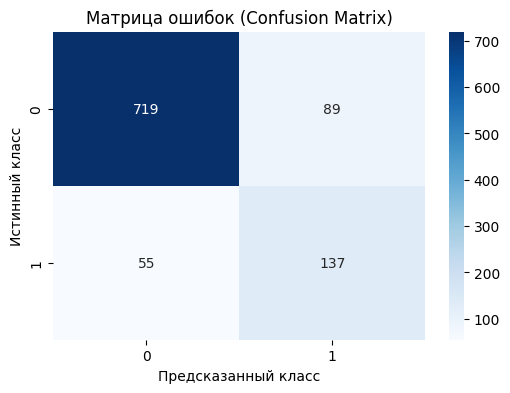

In [24]:
# Предсказания модели
y_pred = predictor.predict(X_test)

# Расчёт F1-метрики
f1 = f1_score(y_test, y_pred)
print(f"F1-метрика: {f1:.4f}")

# Матрица ошибок
from sklearn.metrics import confusion_matrix, f1_score, classification_report

cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)

# Дополнительно — классификационный отчёт
print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()
